# BERTopic Training

### Loading Data

Unlike LDA, we won't be using the preprocessed documents, but rather the unaltered versions.
Hence, we load the original ```.json``` files from disk.

In [18]:
import json

with open('../data/articles/train.json', 'r') as f:
    data = json.load(f)
    texts = [d['text'] for d in data]
    labels = [d['label'] for d in data]

    labels_map = {l: i for i, l in enumerate(set(labels))}
    labels_idx = [labels_map[l] for l in labels]


### Training the Model

We start by testing the default model used by BERTopic, which is SBERT.

In [5]:
from bertopic import BERTopic

topic_model = BERTopic()
topics, probs = topic_model.fit_transform(texts)


### Exploring the Results

While it is possible to evaluate the generated topics in a similar fashion to LDA, i.e., using coherence scores, LLM-based models are at an unfair disadvantage here. To properly compute coherence scores, we would need to preprocess the documents in the same way as we did for LDA. However, while LDA operates directly on this data, LLM-based models do not.

Further, due to the clustering method employed by BERTopic, there is no absolute set of topics. Rather, documents are clustered into topics in a hierachical manner.
This allows for manual intervention, i.e., we can choose a level of granularity that suits our needs.

BERTopic allows us to visualize this hierachy using a dendrogram. We can then select a level of granularity by cutting the dendrogram at a certain height.

In [12]:
topic_model.visualize_hierarchy()


### Evaluation

We can clearly see our four main topics, which are then further divided into subtopics.
To evaluate the quality of these four main topics, we can use the same approach as we did for LDA, i.e., by comparing the generated topics to the ground truth.

Text(0, 0.5, 'Ground Truth')

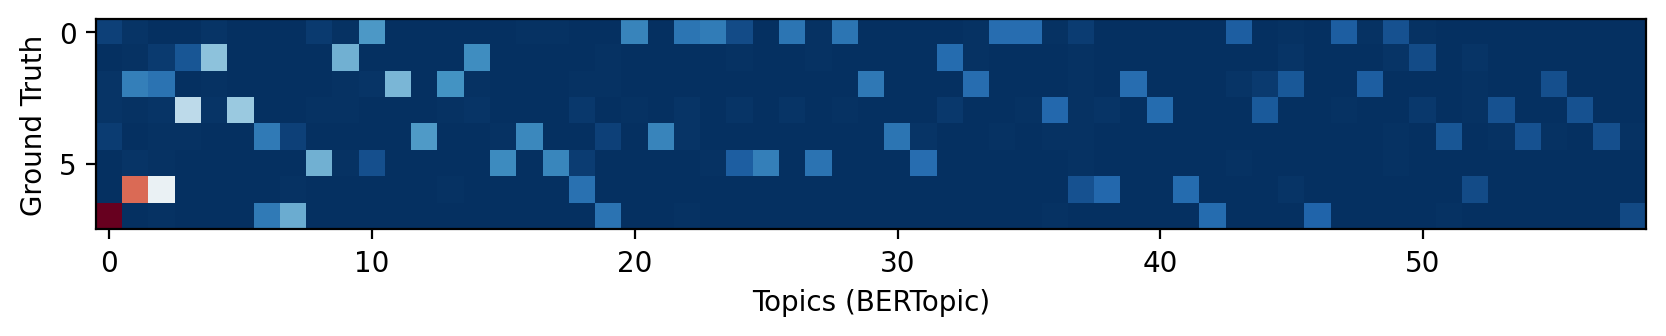

In [53]:
import numpy as np
import matplotlib.pyplot as plt

disc = np.zeros((np.max(labels_idx) + 1))
cooc = np.zeros((np.max(topics) + 1, np.max(labels_idx) + 1))
for topic, label in zip(topics, labels_idx):
    if topic == -1:
        disc[label] += 1
    else:
        cooc[topic, label] += 1

plt.figure(figsize=(10, 2), dpi=200)
plt.imshow(cooc.T, cmap='RdBu_r', interpolation='nearest')
plt.xlabel('Topics (BERTopic)')
plt.ylabel('Ground Truth')
